## This experiment is to apply multiple algorithms and attain the best possible MAP@12 for the problem in hand.

### Approach 1

**Algorithm 1:** Find the most purchased article for each user, he/she is mostly will spent similar bucks in the same item or in some other article which is similar to that.  
This notebook will help us to get this algorithm up and running for each user in training data. I will try to get the top 12 articles which are mostly assumed to be purchased by each user. If any user has purchased less than 12 articles, we will use top selling articles to complete article list till it reaches 12 in count. 

I will dump the submission csv for the entire dataset using this simple algorithm.

**Algorithm 2:** Use LightFM algorithm to find the relation among customer and articles which have seen no interaction in past however the customer may have a tendency to buy these unpurchased articles in future visits. This notebook is already trained and hyperparameters are also optimized based on reduced transaction dates. Store top 200 predictions for each user in training data. Please find the link to these notebooks below:  

Link to Training Light FM model: https://www.kaggle.com/rickykonwar/h-m-lightfm-nofeatures  
Link to Hyper Parameter Tuning Light FM Model: https://www.kaggle.com/rickykonwar/h-m-lightfm-nofeatures-hyperparamter-tuning/notebook

### Approach 2  

**Algorithm 3 (Hybrid):** Once we have set the algorithm 1 and algorithm 2 inferencing outputs, I will form the top 200 recommended articles for each user by combining the most purchases any customer has made (based on algorithm 1) and remaining 200-N will be filled up based on inferencing outputs for the same customer (based on algorithm 2). This combined data will be the base for the hybrid algorithm. On top of these, we will add customer and articles metadata features to clse on the classifier model. 

## Importing Libraries

In [1]:
import os
import gc
import copy
import time
import tqdm
import pickle
import datetime
import numpy as np
import pandas as pd
import scipy.sparse as sparse

from multiprocessing import Pool
from IPython.display import FileLink
from sklearn.model_selection import train_test_split

## Utility Functions

In [2]:
def apk(actual, predicted, k=12):
    '''
    Function to get Average Precision at K
    '''
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0
    
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12):
    '''
    Function to get Mean Average Precision at K
    '''
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def create_chunk_indices(meta_df, chunk_idx, chunk_size):
    '''
    Function to generate chunks of data for multiprocessing
    '''
    start_idx = chunk_idx * chunk_size
    end_idx = start_idx + chunk_size
    meta_chunk = meta_df[start_idx:end_idx]
    print("start/end "+str(chunk_idx+1)+":" + str(start_idx) + "," + str(end_idx))
    print(len(meta_chunk))
    #chunk_idx in return value is used to sort the processed chunks back into original order,
    return (meta_chunk, chunk_idx)

## Data Loading

In [3]:
data_path = r'../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
customer_data_path = r'../input/h-and-m-personalized-fashion-recommendations/customers.csv'
article_data_path = r'../input/h-and-m-personalized-fashion-recommendations/articles.csv'
submission_data_path = r'../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'

In [4]:
# Data Extraction
def create_data(data_path, data_type=None):
    '''
    Reads Input Files 
    
    Parameters:
        datapath (str): File Location for the data file to read
        data_type (str): type of data file to read
        
    Returns:
        df (pandas dataframe): Object for the file
    '''
    if data_type is None:
        df = pd.read_csv(data_path)
    elif data_type == 'transaction':
        df = pd.read_csv(data_path, dtype={'article_id': str}, parse_dates=['t_dat'])
    elif data_type == 'article':
        df = pd.read_csv(data_path, dtype={'article_id': str})
    return df

In [5]:
%%time

# Load all sales data (for 3 years starting from 2018 to 2020)
# ALso, article_id is treated as a string column otherwise it 
# would drop the leading zeros while reading the specific column values
transactions_data=create_data(data_path, data_type='transaction')
print(transactions_data.shape)

# # Unique Attributes
print(str(len(transactions_data['t_dat'].drop_duplicates())) + "-total No of unique transactions dates in data sheet")
print(str(len(transactions_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in data sheet")
print(str(len(transactions_data['article_id'].drop_duplicates())) + "-total No of unique article ids courses names in data sheet")
print(str(len(transactions_data['sales_channel_id'].drop_duplicates())) + "-total No of unique sales channels in data sheet")

(31788324, 5)
734-total No of unique transactions dates in data sheet
1362281-total No of unique customers ids in data sheet
104547-total No of unique article ids courses names in data sheet
2-total No of unique sales channels in data sheet
CPU times: user 1min, sys: 5.31 s, total: 1min 6s
Wall time: 1min 29s


In [6]:
%%time

# Load all Customers
customer_data=create_data(customer_data_path)
print(customer_data.shape)

print(str(len(customer_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in customer data sheet")

(1371980, 7)
1371980-total No of unique customers ids in customer data sheet
CPU times: user 3.97 s, sys: 395 ms, total: 4.36 s
Wall time: 5.8 s


In [7]:
%%time

# Load all Articles
article_data=create_data(article_data_path, data_type='article')
print(article_data.shape)

print(str(len(article_data['article_id'].drop_duplicates())) + "-total No of unique article ids in article data sheet")

(105542, 25)
105542-total No of unique article ids in article data sheet
CPU times: user 849 ms, sys: 30.9 ms, total: 880 ms
Wall time: 1.17 s


In [8]:
%%time

# Load all submission samples data
submission_data=create_data(submission_data_path)
print(submission_data.shape)

print(str(len(submission_data['customer_id'].drop_duplicates())) + "-total No of unique customer ids in submission data sheet")

(1371980, 2)
1371980-total No of unique customer ids in submission data sheet
CPU times: user 3.14 s, sys: 306 ms, total: 3.45 s
Wall time: 5.25 s


## Capturing Seasonal Effect by Limiting the transaction date
Based on notebook with link: https://www.kaggle.com/tomooinubushi/folk-of-time-is-our-best-friend/notebook

In [9]:
transactions_data = transactions_data[transactions_data['t_dat'] > '2020-08-21']
transactions_data.shape

(1190911, 5)

## Splitting transaction data to training and validation set

In [10]:
train_start_date = transactions_data.t_dat.min()
split_date = transactions_data.t_dat.max() - datetime.timedelta(days = 7)
train_transaction_data = transactions_data[(transactions_data.t_dat <= split_date) & (transactions_data.t_dat >= train_start_date)].copy()
test_transaction_data = transactions_data[transactions_data.t_dat > split_date].copy()

print(train_transaction_data.shape)
print(test_transaction_data.shape)

(950600, 5)
(240311, 5)


In [11]:
train_transaction_data = train_transaction_data.groupby(['customer_id','article_id']).agg({'t_dat':'count'}).reset_index()
test_transaction_data = test_transaction_data.groupby(['customer_id','article_id']).agg({'t_dat':'count'}).reset_index()

train_transaction_data.rename({'t_dat': 't_count'}, axis=1, inplace=True)
test_transaction_data.rename({'t_dat': 't_count'}, axis=1, inplace=True)

## Algorithm 1: Extracting Topmost articles for each user based on number of purchase made

In [12]:
train_val_merge_transaction_data = train_transaction_data[train_transaction_data.article_id.isin(test_transaction_data.article_id.unique())] 
train_top_articles = train_val_merge_transaction_data.sort_values(['customer_id', 't_count'], ascending=False).groupby(['customer_id']).head(12)
test_top_articles = test_transaction_data.sort_values(['customer_id', 't_count'], ascending=False).groupby(['customer_id']).head(12)

# Overall highly sold articles
overall_top_articles = train_top_articles.groupby(['article_id'], as_index = False)['t_count'].sum().sort_values(['t_count'])['article_id'][-12:].values
overall_top_articles = overall_top_articles[::-1]

In [13]:
train_top_articles.head(10)

,customer_id,article_id,t_count
842892,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0689365050,1
842893,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027,1
842894,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0794819001,1
842895,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0884081001,1
842886,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022,1
842887,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0713997002,1
842888,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0720125039,1
842889,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0740922009,1
842890,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0791587007,1
842891,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0804992033,1


In [14]:
test_top_articles.head(10)

,customer_id,article_id,t_count
213727,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,0898573003,1
213725,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,0750423010,1
213726,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,0761269001,1
213722,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0865624003,2
213715,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0396135007,1
213716,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0715624050,1
213717,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0797892001,1
213718,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0817472003,1
213719,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0817472007,1
213720,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0826150004,1


In [15]:
overall_top_articles

array(['0751471001', '0706016001', '0915526001', '0751471043',
       '0918292001', '0915529003', '0898694001', '0448509014',
       '0863595006', '0896152002', '0850917001', '0915526002'],
      dtype=object)

### Evaluating this algorithm

In [16]:
%%time

def perform_cross_validation(): 
    '''
    Performs Cross Validation for training and test transactions separated by 1 week
    
    Parameters:
        None
        
    Returns:
        preds (str, list): list of articles that have been predicted
        trues (str, list); list of articles that have actually been bought
    '''
    preds, trues = [],[]
    for customer in tqdm.tqdm(train_top_articles.customer_id.unique(), desc='Evaluating Simple Algorithm'):

        predict_n_articles = train_top_articles[train_top_articles.customer_id.isin([customer])]['article_id'].values[:12]
        actual_n_articles = test_top_articles[test_top_articles.customer_id.isin([customer])]['article_id'].values[:12]

        if len(predict_n_articles) < 12:
            predict_n_articles = list(predict_n_articles[:len(predict_n_articles)]) + list(overall_top_articles[:12 - len(predict_n_articles)])

        preds.append(list(predict_n_articles))
        trues.append(list(actual_n_articles))
    return preds, trues

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [17]:
preds = []
trues = []

if os.path.exists(r'../input/hm-trained-models/hybrid_generic/hybrid_simplealgo_actuals.pkl') and os.path.exists(r'../input/hm-trained-models/hybrid_generic/hybrid_simplealgo_preds.pkl'):

    with open(r'../input/hm-trained-models/hybrid_generic/hybrid_simplealgo_actuals.pkl', 'rb') as input_file:
        trues = pickle.load(input_file)
    with open(r'../input/hm-trained-models/hybrid_generic/hybrid_simplealgo_preds.pkl', 'rb') as input_file:
        preds = pickle.load(input_file)
else:
    preds, trues = perform_cross_validation()

#### Screenshot for predictions and actuals extraction

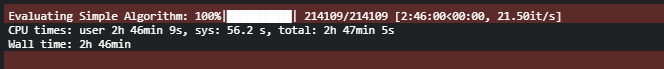

In [18]:
# Save Predictions and Actual
with open('hybrid_simplealgo_preds.pkl', 'wb') as f:
    pickle.dump(preds, f)
with open('hybrid_simplealgo_actuals.pkl', 'wb') as f:
    pickle.dump(trues, f)

In [19]:
score = np.round(mapk(trues, preds, k = 12), 5)
print(f'MAP@{12} = {score}')

MAP@12 = 0.00606


### Getting Submission data from entire transaction data

In [20]:
purchase_dict = {}

for i,x in enumerate(zip(transactions_data['customer_id'], transactions_data['article_id'])):
    cust_id, art_id = x
    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}
    
    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    purchase_dict[cust_id][art_id] += 1
    
print(len(purchase_dict))

256355


In [21]:
final_submission_data = submission_data[['customer_id']].copy()
prediction_list = []
top_articles_list = list((transactions_data['article_id'].value_counts()).index)[:12]
top_prediction_string = ' '.join(top_articles_list)

for i, cust_id in enumerate(submission_data['customer_id'].values.reshape((-1,))):
    if cust_id in purchase_dict:
        l = sorted((purchase_dict[cust_id]).items(), key=lambda x: x[1], reverse=True)
        l = [y[0] for y in l]
        if len(l)>12:
            s = ' '.join(l[:12])
        else:
            s = ' '.join(l+top_articles_list[:(12-len(l))])
    else:
        s = top_prediction_string
    prediction_list.append(s)

final_submission_data['prediction'] = prediction_list
print(final_submission_data.shape)

(1371980, 2)


In [22]:
final_submission_data.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0751471001 0915529003 0915526001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0915529003 0915526001 0918292001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0751471001 0915529003 0915526001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0915529003 0915526001 0918292001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0915529003 0915526001 0918292001 07...


### Writing Algo 1 Submissions

In [23]:
final_submission_data.to_csv("hybrid_algo1_submission.csv", index=False)
del final_submission_data
gc.collect()

0

In [24]:
FileLink(r'hybrid_algo1_submission.csv')

/kaggle/working/hybrid_algo1_submission.csv

## Algorithm 2: Load already trained lightfm model and predict top 200 articles for each user in training data

In [25]:
lightfm_model_path = r'../input/hm-trained-models/lightfm_nofeatures/model_without_feature_optimized_01.pickle'
lightfm_model = pickle.load(open(lightfm_model_path, 'rb'))

In [26]:
class recommendation_sampling():
    def __init__(self, model, items = None, user_to_product_interaction_matrix = None, 
                item_features = None, user2index_map = None):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.item_features = item_features if item_features is not None else None
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
        
    def get_batched_recommendation(self, user, k=3, prediction_type='normal'):
        # Getting user_indexes 
        user_index = self.user2index_map.get(user, None)
        if user_index is None:
            return None
        
        # Scores from model
        scores = self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
    
        # Top items
        top_items = self.items[np.argsort(-scores)][:k]
        top_scores = np.sort(-scores)[::-1][:k]
        
        return top_items, top_scores
    
    def get_batched_recommendation_df(self, user, k=3, prediction_type='normal'):
        # Getting user_indexes 
        user_index = self.user2index_map.get(user, None)
        if user_index is None:
            return None
        
        # Scores from model
        scores = self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
    
        return scores

def get_customers_list():
    '''
    Generates list of unique customers
    
    Parameters:
        None
        
    Returns:
        list of unique customers in customer data
    '''
    return np.sort(customer_data['customer_id'].unique())

def get_articles_list():
    '''
    Generates list of unique articles
    
    Parameters:
        None
        
    Returns:
        list of unique articles in articles data
    '''  
    item_list = article_data['article_id'].unique()
    return item_list

def id_mappings(customers_list, articles_list):
    '''
    Create id mappings to convert customer_id, article_id and feature_id
    
    Parameters:
        customers_list (str, list): list of customers in customer data
        articles_list (str, list): list of articles in articles data
        
    Returns:
        list of unique articles in articles data
    '''  
    customer_to_index_mapping = {}
    index_to_customer_mapping = {}
    for customer_index, customer_id in enumerate(customers_list):
        customer_to_index_mapping[customer_id] = customer_index
        index_to_customer_mapping[customer_index] = customer_id
        
    article_to_index_mapping = {}
    index_to_article_mapping = {}
    for article_index, article_id in enumerate(articles_list):
        article_to_index_mapping[article_id] = article_index
        index_to_article_mapping[article_index] = article_id
        
    return customer_to_index_mapping, index_to_customer_mapping, \
           article_to_index_mapping, index_to_article_mapping

def get_customer_article_interaction(customer_article_amt_df):
    '''
    Create customer article interaction matrix based on total amount spent by each
    customer towards each article
    
    Parameters:
        customer_article_amt_df (str, list): Grouped transaction data based on total amount spent for each customer in transactions data
        
    Returns:
        Categorical Converted grouped transaction data based on total amount spent
    '''  
    #start indexing
    customer_article_amt_df["customer_id"] = customer_article_amt_df["customer_id"]
    customer_article_amt_df["article_id"] = customer_article_amt_df["article_id"]
    customer_article_amt_df["price"] = customer_article_amt_df["price"]

    # Preprocessing dataframe created
    customer_article_amt_df = customer_article_amt_df.rename(columns = {"price":"total_amount_spent"})

    # Replace Amount Column with category codes 
    customer_article_amt_df['total_amount_spent'] = customer_article_amt_df['total_amount_spent'].astype('category')
    customer_article_amt_df['total_amount_spent'] = customer_article_amt_df['total_amount_spent'].cat.codes

    return customer_article_amt_df

def get_interaction_matrix(df, df_column_as_row, df_column_as_col, 
                        df_column_as_value, row_indexing_map, col_indexing_map):
    '''
    Generate Sprase Interaction Matrix based on unique customer and articles indices as light FM can only work
    based on index values
    
    Parameters:
        df (pd dataframe): Base Dataframe to be converted to matrix format
        df_column_as_row (str): Column name from base dataframe to be considered on row end of matrix
        df_column_as_col (str): Column name from base dataframe to be considered on column end of matrix
        df_column_as_value (str): Values which are to be treated to fill up the cell spaces between rows and columns
        row_indexing_map (dict): Index Mapping for each customer
        col_indexing_map (dict): Index Mapping for each article
        
    Returns:
        Sparse Interaction matrix between customers and articles based on all customers and articles data
    '''  
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

In [27]:
customers = get_customers_list()
articles = get_articles_list()
customer_to_index_mapping, index_to_customer_mapping, \
article_to_index_mapping, index_to_article_mapping = id_mappings(customers, articles)

In [28]:
transactions_data_grouped = transactions_data.groupby(['customer_id','article_id']).agg({'price':'sum','t_dat':'count'}).reset_index()
transactions_data_grouped = transactions_data_grouped[['customer_id','article_id','price']]

In [29]:
customer_to_article = get_customer_article_interaction(customer_article_amt_df = transactions_data_grouped[['customer_id','article_id','price']])
customer_to_article_interaction = get_interaction_matrix(customer_to_article, "customer_id", "article_id", "total_amount_spent", \
                                                        customer_to_index_mapping, article_to_index_mapping)            

In [30]:
customer_to_article.head()

,customer_id,article_id,total_amount_spent
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043,4205
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,4791
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0448509014,3443
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0719530003,2792
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0516859008,939


In [31]:
customer_to_article_interaction

<1371980x105542 sparse matrix of type '<class 'numpy.int16'>'
	with 1051730 stored elements in COOrdinate format>

In [32]:
# Sampling Recommendations
recom_without_feature = recommendation_sampling(model = lightfm_model,
                                               items = articles,
                                               user_to_product_interaction_matrix = customer_to_article_interaction,
                                               user2index_map = customer_to_index_mapping)

In [33]:
# Light FM Important Params
n_top = 200
lightfm_top_200_predictions_df = pd.DataFrame()

### Predicting for unique customers in training (transaction) data

In [34]:
num_cores=4

def predict_top_200_articles_submethod(chunk_training_data=None):
    '''
    Submethod for predicting top 200 articles for chunked training data
    
    Parameters:
        chunk_training_data (pd dataframe): Chunk Sized dataframe to be processed for extracting predictions
        
    Returns:
        lightfm_predictions_df (pd dataframe): top 200 predicted articles for each customer in the chunked training data
    '''  
    lightfm_predictions_df = pd.DataFrame()
    
    for customer in tqdm.tqdm(chunk_training_data['customer_id'].unique(), desc='Predicting top 200 articles for each user'):

        articles_df = pd.DataFrame(articles, columns = ['article_id'])
        articles_df['customer_id'] = customer
        articles_df['lightfm_score'] = recom_without_feature.get_batched_recommendation_df(customer, len(articles))
        articles_df.sort_values('lightfm_score', ascending = False, inplace = True)
        articles_df['lightfm_rank'] = np.arange(articles_df.shape[0])

        lightfm_predictions_df = lightfm_predictions_df.append(articles_df.head(n_top))
        
    return lightfm_predictions_df

def predict_top_200_articles(training_data=None):
    '''
    Generating top 200 articles predictions data for each customer in transactions data by speeding the process
    using multiprocessing
    
    Parameters:
        training_data (pd dataframe): Unique Customer IDs in transactios data
        
    Returns:
        result_combined_df (pd dataframe): Top 200 predicted articles for each customer in transactions data
    '''  
    #splitting here by measurement id's to get all signals for a measurement into single chunk
    customer_ids = training_data["customer_id"].unique()
    df_split = np.array_split(customer_ids, num_cores)
    chunk_size = len(df_split[0])
    
    chunk1 = create_chunk_indices(training_data, 0, chunk_size)
    chunk2 = create_chunk_indices(training_data, 1, chunk_size)
    chunk3 = create_chunk_indices(training_data, 2, chunk_size)
    chunk4 = create_chunk_indices(training_data, 3, chunk_size)
    
    #list of items for multiprocessing, 4 since using 4 cores
    all_chunks = [chunk1[0], chunk2[0], chunk3[0], chunk4[0]]
    
    pool = Pool(num_cores)
    result = pool.map(predict_top_200_articles_submethod, all_chunks)
    
    result_combined_df = pd.concat([result[0], result[1], result[2], result[3]], axis=0)
    return result_combined_df

In [35]:
%%time

if os.path.exists(r'../input/hm-trained-models/hybrid_generic/lightfm_top_200_predictions.parquet'):
    lightfm_top_200_predictions_df = pd.read_parquet(r'../input/hm-trained-models/hybrid_generic/lightfm_top_200_predictions.parquet')
    lightfm_top_200_predictions_df = lightfm_top_200_predictions_df[['customer_id','article_id','lightfm_score', 'lightfm_rank']]
    lightfm_top_200_predictions_df = lightfm_top_200_predictions_df.reset_index(drop=True)
else:
    training_lfm_data = transactions_data.copy()[['customer_id']].drop_duplicates(subset=['customer_id'])
    
    lightfm_top_200_predictions_df = predict_top_200_articles(training_lfm_data)
    lightfm_top_200_predictions_df = lightfm_top_200_predictions_df[['customer_id','article_id','lightfm_score', 'lightfm_rank']]
    lightfm_top_200_predictions_df = lightfm_top_200_predictions_df.reset_index(drop=True)
    lightfm_top_200_predictions_df.to_parquet('lightfm_top_200_predictions.parquet')
lightfm_top_200_predictions_df.shape

CPU times: user 10.3 s, sys: 9.36 s, total: 19.6 s
Wall time: 18.7 s


(51271000, 4)

#### Screenshot of inferencing top 200 articles for all customers in training data
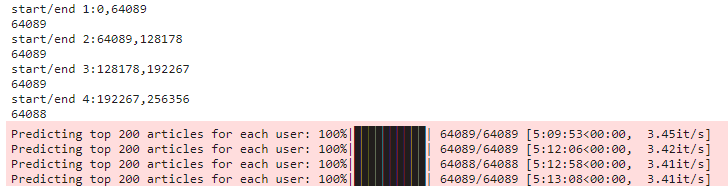

In [36]:
# lightfm_top_200_predictions_df['customer_index'] = lightfm_top_200_predictions_df['customer_id'].map(lambda x: customer_to_index_mapping.get(x))
# lightfm_top_200_predictions_df['article_index'] = lightfm_top_200_predictions_df['article_id'].map(lambda x: article_to_index_mapping.get(x))

## Algorithm 3: Hybrid Modelling 


### Hybrid Data Compilation (Combining top N articles seen by each customer + (200-N) based on lightfm predictions for the same customer)

In [37]:
hybrid_params = {'top_n':200}

### Fill up top N articles  
1. Based on transaction counts for known customers  
2. Fill up remaining (200-N) articles based on lightfm predictions fot these set of customers
3. Fill up top N articles for unseen customer based on overall top selling articles

In [38]:
# Hybrid Important Params
hybrid_top_200_predictions_df = pd.DataFrame()

In [39]:
# Generate the dictionary version of top 200 lightfm based predictions
lightfm_top_200_predictions_dict = lightfm_top_200_predictions_df.groupby('customer_id').agg({'article_id' : ', '.join}).to_dict()['article_id']

In [40]:
def extract_lightfm_articles(customer_id, algo_1_article_list, remaining_article_count):
    '''
    Extracting remaining articles from light FM based predictions
    
    Parameters:
        customer_id (str): Unique Customer IDs to process
        algo_1_article_list (str, list): List of actual purchases made by this specific customer
        remaining_article_count (int): items to extract from light FM based predictions
        
    Returns:
        final_lightfm_article (str, list): List of aticles to be returned
    '''  
    lightfm_article = None
    final_lightfm_article = []
    
    lightfm_article = lightfm_top_200_predictions_dict.get(customer_id)
    final_lightfm_article = [article for article in lightfm_article.split(', ') if article not in algo_1_article_list][:remaining_article_count]
    
    return final_lightfm_article

def predict_hybrid_top_200_articles_submethod(training_data=None):
    '''
    Generating top hyrbidized 200 articles predictions data for each customer in chunked transactions data 
    
    Parameters:
        training_data (pd dataframe): Actual purchased made by each customer in the chunked transactions data
        
    Returns:
        hybrid_predictions_df (pd dataframe): Top hybridized 200 predicted articles for each customer in chunked transactions data
    '''  
    hybrid_predictions_df = training_data.copy()
    
    for customer_id, group in tqdm.tqdm(training_data.groupby(['customer_id']), desc='Hybrid prediction compilation for Training Customers'):
        if group.shape[0] < n_top:

            remaining_article_count = n_top - group.shape[0]
            
            addl_lightfm_articles = extract_lightfm_articles(customer_id, list(group.article_id.unique()), remaining_article_count)
            addl_lightfm_articles = pd.DataFrame(addl_lightfm_articles, columns = ['article_id'], dtype=str)
            addl_lightfm_articles['customer_id'] = customer_id
            addl_lightfm_articles['customer_article_freq'] = 0

            hybrid_predictions_df = hybrid_predictions_df.append(addl_lightfm_articles[['customer_id', 'article_id', 'customer_article_freq']])
    
    return hybrid_predictions_df

def predict_hybrid_top_200_articles(training_data=None):
    '''
    Generating top hyrbidized 200 articles predictions data for each customer in transactions data by speeding the process
    using multiprocessing
    
    Parameters:
        training_data (pd dataframe): Actual purchased made by each customer in the transactions data
        
    Returns:
        hybrid_predictions_df (pd dataframe): Top hybridized 200 predicted articles for each customer in transactions data
    '''
    #splitting here by customer id
    customer_ids = training_data["customer_id"].unique()
    df_split = np.array_split(customer_ids, num_cores)
    chunk_size = len(df_split[0])
    
    chunk1 = create_df_chunk_indices(training_data, 0, chunk_size, 'customer_id')
    chunk2 = create_df_chunk_indices(training_data, 1, chunk_size, 'customer_id')
    chunk3 = create_df_chunk_indices(training_data, 2, chunk_size, 'customer_id')
    chunk4 = create_df_chunk_indices(training_data, 3, chunk_size, 'customer_id')
    
    #list of items for multiprocessing, 4 since using 4 cores
    all_chunks = [chunk1[0], chunk2[0], chunk3[0], chunk4[0]]
    
    pool = Pool(num_cores)
    result = pool.map(predict_hybrid_top_200_articles_submethod, all_chunks)
    
    result_combined_df = pd.concat([result[0], result[1], result[2], result[3]], axis=0)
    return result_combined_df
    
def create_df_chunk_indices(df, chunk_idx, chunk_size, unique_column = 'customer_id'):
    '''
    Function to generate chunks of groupby dataframe for multiprocessing
    '''
    start_idx = chunk_idx * chunk_size
    end_idx = start_idx + chunk_size
    unique_list = list(df[unique_column].unique())
    chunk_df = df.loc[df[unique_column].isin(unique_list[start_idx:end_idx])].reset_index(drop=True)
    print("start/end "+str(chunk_idx+1)+":" + str(start_idx) + "," + str(end_idx))
    print(len(chunk_df))
    return (chunk_df, chunk_idx)

In [41]:
%%time 

if os.path.exists(r'../input/hm-trained-models/hybrid_generic/hybrid_top_200_predictions.parquet'):
    hybrid_top_200_predictions_df = pd.read_parquet(r'../input/hm-trained-models/hybrid_generic/hybrid_top_200_predictions.parquet')
else:
    training_wlfm_df = transactions_data.copy().groupby(['customer_id','article_id']).agg({'t_dat':'count'})
    training_wlfm_df = training_wlfm_df.rename(columns={'t_dat':'customer_article_freq'})
    training_wlfm_df = training_wlfm_df.sort_values(['customer_article_freq'])
    training_wlfm_df = training_wlfm_df.reset_index()
    
    # training_wlfm_df = training_wlfm_df.loc[training_wlfm_df.customer_id.isin(list(training_wlfm_df.customer_id.unique())[:2000])].reset_index(drop=True)
    hybrid_top_200_predictions_df = predict_hybrid_top_200_articles(training_wlfm_df)
    hybrid_top_200_predictions_df = hybrid_top_200_predictions_df.sort_values(by='customer_id').reset_index(drop=True)
    hybrid_top_200_predictions_df.to_parquet('hybrid_top_200_predictions.parquet')
hybrid_top_200_predictions_df.shape

CPU times: user 7.14 s, sys: 3.71 s, total: 10.8 s
Wall time: 10.2 s


(51271000, 3)

#### Screenshot of inferencing hybrid top 200 articles for all customers in training data
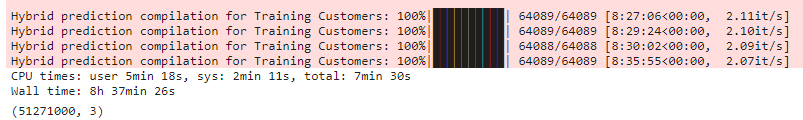

In [42]:
# hybrid_top_200_predictions_df = pd.merge(hybrid_top_200_predictions_df, lightfm_top_200_predictions_df[['customer_id','article_id', 'lightfm_score']], how='left', on=['customer_id','article_id'])
# hybrid_top_200_predictions_df.head(10)

### Generate target column and related features

In [43]:
# # Target Column Generation
# def generate_target(train_df=None):
#     if train_df is not None:
#         train_df['article_purchased'] = train_df['customer_article_freq'].apply(lambda x: 1 if int(x)>0 else 0)
#     return train_df

In [44]:
# def generate_features(train_df=None, feature_flag=[False]*3):
#     if train_df is not None and len(feature_flag)>0:
#         final_train_shape = train_df.shape[0]
        
#         '''
#         3 features at scope - customer article rank based on purchase count,
#         customer article rank based on light FM interactions,
#         combined rank which is attained by averaging purchase rank and light FM rank
#         '''
#         if feature_flag[0]:
#             print('Generating Purchase and Light FM Ranks Started')
#             if 'customer_purchase_rank' not in train_df.columns:
#                 # Collect prediction rank based on purchase counts
#                 for customer_id, group in tqdm.tqdm(train_df.sort_values(['customer_id', 'customer_article_freq'], ascending = False).groupby(['customer_id']), desc='Generating Customer Purchase Ranks'):
#                     train_df.loc[group.index, 'customer_purchase_rank'] = np.arange(0, group.shape[0])
#                 train_df.loc[train_df[train_df.customer_article_freq == 0].index, 'customer_purchase_rank'] = 62

#             if 'customer_lfm_rank' not in train_df.columns:
#                 # Collect prediction rank based on lightfm score
#                 for customer_id, group in tqdm.tqdm(train_df.sort_values(['customer_id', 'lightfm_score'], ascending = False).groupby(['customer_id']), desc='Generating Customer Light FM Ranks'):
#                     train_df.loc[group.index, 'customer_lfm_rank'] = np.arange(0, group.shape[0])
#                 train_df.loc[train_df[pd.isnull(train_df.lightfm_score)].index, 'customer_lfm_rank'] = 200

#             if 'combined_rank' not in train_df.columns:
#                 # mean rank
#                 train_df['combined_rank'] = (train_df['customer_purchase_rank'] + train_df['customer_lfm_rank']) / 2
#             print('Generating Purchase and Light FM Ranks Completed')
#         '''
#         5 features at scope - article product group name, 
#         article index group name,
#         article product type name,
#         article graphical appearance name,
#         aricle colour group name
#         '''
#         if feature_flag[1]:
#             print('Generating Article Based Features Started')
#             if 'product_group_name' not in train_df.columns or \
#             'index_group_name' not in train_df.columns or \
#             'product_type_name' not in train_df.columns or \
#             'graphical_appearance_name' not in train_df.columns or \
#             'colour_group_name' not in train_df.columns:
#                 article_info_df = article_data[['article_id', 'product_group_name', 'index_group_name', 'product_type_name', 'graphical_appearance_name', 'colour_group_name']].drop_duplicates()
#                 train_df = pd.merge(train_df, article_info_df, how='left', on='article_id')
#                 assert final_train_shape==train_df.shape[0]
#             print('Generating Article Based Features Completed')
#         '''
#         2 features at scope - customer bias and article bias
#         '''
#         if feature_flag[2]:
#             print('Generating Customer and Article Biases Features Started')
#             if 'customer_bias_lfm' not in train_df.columns:
#                 # Collect user biases
#                 customer_bias_df = pd.DataFrame(lightfm_model.user_biases, columns = ['customer_bias_lfm'])
#                 customer_bias_df['customer_id'] = customers
#                 train_df = train_df.merge(customer_bias_df, on = ['customer_id'], how = 'left')
#                 assert final_train_shape==train_df.shape[0]

#             if 'article_bias_lfm' not in train_df.columns:
#                 # Collect item biases
#                 article_bias_df = pd.DataFrame(lightfm_model.item_biases, columns = ['article_bias_lfm'])
#                 article_bias_df['article_id'] = articles
#                 train_df = train_df.merge(article_bias_df, on = ['article_id'], how = 'left')
#                 assert final_train_shape==train_df.shape[0]
#             print('Generating Customer and Article Biases Features Completed')

#     return train_df

In [45]:
# if os.path.exists(r'../input/hm-trained-models/hybrid_generic/hybrid_training_data.parquet'):
#     train_df = pd.read_parquet(r'../input/hm-trained-models/hybrid_generic/hybrid_training_data.parquet')
# else:
#     # Generating Target Column
#     train_df = generate_target(hybrid_top_200_predictions_df.copy())
#     print(train_df['article_purchased'].value_counts())

#     # Feature Engineering
#     train_df = generate_features(train_df, [True, True, True])

#     train_df.to_parquet(r'hybrid_training_data.parquet')
# train_df.shape

In [46]:
# train_df

In [47]:
# del [[lightfm_top_200_predictions_df, lightfm_top_200_predictions_dict, hybrid_top_200_predictions_df]]
# gc.collect()

In [48]:
# train_df.head()

## Training using Light GBM 

### Model Validation (Train Test Split)

In [49]:
# cat_columns = ['product_group_name', 'index_group_name', 'product_type_name', 'graphical_appearance_name', 'colour_group_name']
# label_encoder = LabelEncoder()
# for col in tqdm.tqdm(cat_columns, desc='Label encoding categorical columns'):
#     train_df[col] = label_encoder.fit_transform(train_df[col])
# train_df.head()

In [50]:
# customers_train, customers_test = train_test_split(train_df.customer_id.unique(), train_size=0.8, random_state=42)
# target_col = 'article_purchased'

In [51]:
# X_train = train_df[train_df.customer_id.isin(customers_train)].copy()
# X_test = train_df[train_df.customer_id.isin(customers_test)].copy()
# y_train = X_train.pop(target_col)
# y_test = X_test.pop(target_col)

# X_train = X_train.set_index(['customer_id', 'article_id'])
# X_test = X_test.set_index(['customer_id', 'article_id'])
# print(X_train.shape, X_test.shape)
# print('Features:', list(X_train.columns))

In [52]:
# optimized_params = {
#                 'n_estimators': 10000,
#                 'learning_rate': 0.27736469655066487,
#                 'num_leaves': 1400,
#                 'max_depth': 5,
#                 'min_data_in_leaf': 6400,
#                 'lambda_l1': 15,
#                 'lambda_l2': 80,
#                 'min_gain_to_split': 0.09658265522474352,
#                 'bagging_fraction': 0.9,
#                 'bagging_freq': 1,
#                 'feature_fraction': 0.9}
# best_params = {
#             'objective': 'binary',
#             'metric': 'binary_error',
#             'verbosity': -1,
#             'boosting_type': 'gbdt',
#             'seed': 42} 

In [53]:
# train_data = lgb.Dataset(X_train, y_train)
# test_data = lgb.Dataset(X_test, y_test)

# param = best_params.update(optimized_params)

# res = {}
# bst = lgb.train(
#     param, train_data, 
#     valid_sets=[train_data, test_data], 
#     valid_names=["train", "valid"],
#     categorical_feature = cat_columns,
#     num_boost_round=50000,
#     callbacks=[early_stopping(1000), log_evaluation(100), record_evaluation(res)])

In [54]:
# X_test['lgb_score'] = bst.predict(X_test, num_iteration=bst.best_iteration)
# lgb_res = X_test.reset_index([0, 1])[['customer_id',
#                                     'article_id',
#                                     'lgb_score']].sort_values('lgb_score',
#                                                             ascending=False)

In [55]:
# preds = []
# trues = []
# for customer_id, group in tqdm.tqdm(lgb_res.groupby('customer_id'), desc='Evaluating Light GBM Ranking Model'):
#     predict_n_articles = list(group.article_id)[:12]
#     actual_n_articles = list(purchase_dict.get(customer_id).keys())[:12]
    
#     preds.append(list(predict_n_articles))
#     trues.append(list(actual_n_articles))
    
# score = np.round(mapk(trues, preds, k = 12), 5)
# print(f'Model MAP@{12} = {score}')

In [56]:
# lgb.plot_importance(bst, figsize = (15, 10));

## Writing Submission file with highly purchased articles by each customer followed by the remaining articles based on customer age category

In [57]:
hybrid_submission_file = pd.read_csv(r'../input/hm-trained-models/hybrid_generic/hybrid_algo1_submission_v02.csv')
hybrid_submission_file

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0751471001 0915529003 0706016001 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0915529003 0915526001 0918292001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0915526001 0706016001 0918292001 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0915529003 0915526001 0918292001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0915529003 0915526001 0918292001 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0713997002 0720125039 0740922009 0791587007 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0915529003 0915526001 0918292001 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0689365050 0884081001 0794819001 0762846027 09...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0915529003 0915526001 0918292001 07...


In [58]:
hybrid_submission_file.to_csv('submission.csv', index=False)